# Import modules

In [1]:
import os
import glob
import shutil
from tqdm import tqdm
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from osgeo import gdal

import rasterio

from keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import *
from sklearn.metrics import jaccard_score

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Load data

In [4]:
meta = pd.read_csv('STAC_Overflow_Map_Floodwater_from_Radar_Imagery_-_Training_metadata.csv')
meta = meta.drop_duplicates('chip_id').reset_index(drop=True)

In [5]:
filenames = [x.split('.')[0] for x in os.listdir('train_labels/')]

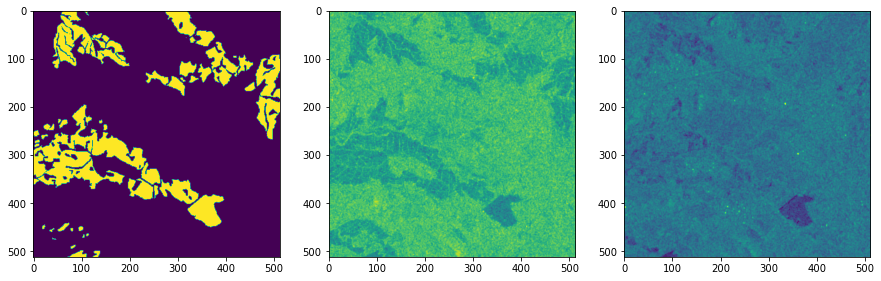

In [6]:
fn = filenames[4]

for fn in filenames[17:18]:
    
    with rasterio.open('train_features/{}_vv.tif'.format(fn)) as fvv:
        vv = fvv.read(1)
    with rasterio.open('train_features/{}_vh.tif'.format(fn)) as fvh:
        vh = fvh.read(1)
    with rasterio.open('train_labels/{}.tif'.format(fn)) as fmask:
        mask = fmask.read(1)
        
    _, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(mask)
    ax[1].imshow(vh)
    ax[2].imshow(vv)
    plt.show()

# Data Generator

## Functions

The value 255 means empty zones in the photo. I convert them to zeros.

In [7]:
def process_mask(mask):
    mask_temp = mask.copy()
    mask_temp[mask == 255] = 0
    return mask_temp

I didn't use any complicated augmentations so as not to damage the image.

In [8]:
def augment_image(image, mask):

    aug = A.Compose([
        
        A.RandomResizedCrop(512, 512, scale=(0.75, 1.0), p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Blur(p=0.5),
    
    ])

    augmented = aug(image=image, mask=mask)

    return augmented['image'], augmented['mask']

The DataGenerator implies the possibility of using several combinations of image channels. Scaling of each band is performed according to the formula 


(X - band_mean) / band_std


band_mean - mean value of band on all images


band_std - std value of band on all images

In [9]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, paths,
                 augment=True,
                 batch_size=16,
                 input_shape=512,
                 shuffle=True,
                 channels=2):
        
        self.channels = channels
        self.paths = paths
        self.augment = augment
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.paths)
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    def __load_data(self, paths):
    
        X_batch = []
        y_batch = []
        
        for path in paths:

            with rasterio.open('train_features/{}_vv.tif'.format(path)) as fvv:
                vv = fvv.read(1)
            with rasterio.open('train_features/{}_vh.tif'.format(path)) as fvh:
                vh = fvh.read(1)
            
            with rasterio.open('train_features/{}_nasadem.tif'.format(path)) as nasadem_:
                nasadem = nasadem_.read(1)
            with rasterio.open('train_features/{}_jrc-gsw-change.tif'.format(path)) as jrc_gsw_change_:
                jrc_gsw_change = jrc_gsw_change_.read(1)
            with rasterio.open('train_features/{}_jrc-gsw-extent.tif'.format(path)) as jrc_gsw_extent_:
                jrc_gsw_extent = jrc_gsw_extent_.read(1)
            with rasterio.open('train_features/{}_jrc-gsw-occurrence.tif'.format(path)) as jrc_gsw_occurrence_:
                jrc_gsw_occurrence = jrc_gsw_occurrence_.read(1)
            with rasterio.open('train_features/{}_jrc-gsw-recurrence.tif'.format(path)) as jrc_gsw_recurrence_:
                jrc_gsw_recurrence = jrc_gsw_recurrence_.read(1)
            with rasterio.open('train_features/{}_jrc-gsw-seasonality.tif'.format(path)) as jrc_gsw_seasonality_:
                jrc_gsw_seasonality = jrc_gsw_seasonality_.read(1)
            with rasterio.open('train_features/{}_jrc-gsw-transitions.tif'.format(path)) as jrc_gsw_transitions_:
                jrc_gsw_transitions = jrc_gsw_transitions_.read(1)
            
            with rasterio.open('train_labels/{}.tif'.format(path)) as fmask:
                mask = process_mask(fmask.read(1))
            
            if self.channels == 2:
                X = np.zeros((512, 512, 2))
                X[:, :, 0] = (vh - (-17.54)) / 5.15
                X[:, :, 1] = (vv - (-10.68)) / 4.62
                
            elif self.channels == 3:
                X = np.zeros((512, 512, 3))
                X[:, :, 0] = (vh - (-17.54)) / 5.15
                X[:, :, 1] = (vv - (-10.68)) / 4.62
                X[:, :, 2] = (nasadem - (166.47)) / 178.47
                
            elif self.channels == 9:
                X = np.zeros((512, 512, 9))
                X[:, :, 0] = (vh - (-17.54)) / 5.15
                X[:, :, 1] = (vv - (-10.68)) / 4.62
                X[:, :, 2] = (nasadem - (166.47)) / 178.47
                X[:, :, 3] = (jrc_gsw_change - 238.76) / 45.45
                X[:, :, 4] = (jrc_gsw_occurrence - 6.50) / 29.06
                X[:, :, 5] = (jrc_gsw_extent - 2.15) / 22.71
                X[:, :, 6] = (jrc_gsw_recurrence - 10.04) / 33.21
                X[:, :, 7] = (jrc_gsw_seasonality - 2.60) / 22.79
                X[:, :, 8] = (jrc_gsw_transitions - 0.55) / 1.94
            
            y = mask.copy()
            
            if self.augment:
                X, y = augment_image(X, mask)
                
            X_batch.append(X)
            y_batch.append(y)
            
        return np.array(X_batch, dtype=float), np.array(y_batch, dtype=float)
    
    
    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__load_data([self.paths[i] for i in indexes])        
        
        return X, y
    
    
    def __len__(self):
        
        return int(np.floor(len(self.paths) / self.batch_size))

## Viewing data

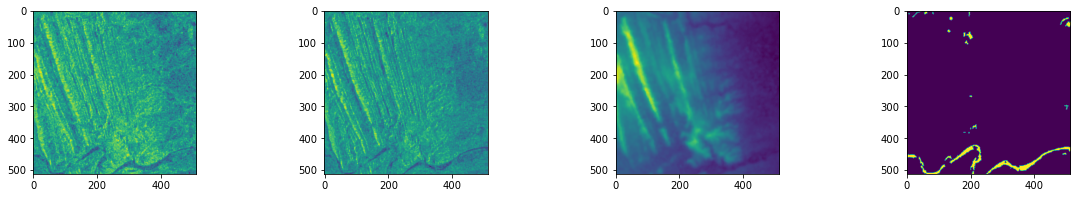

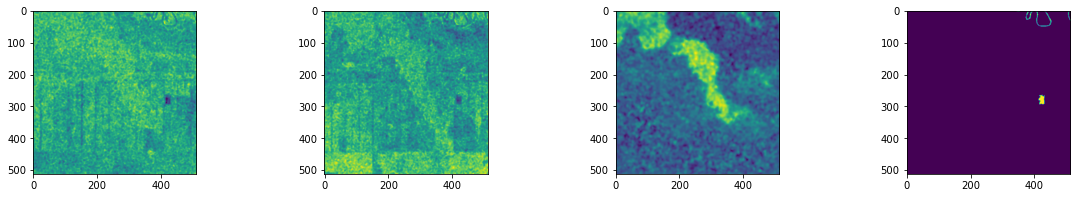

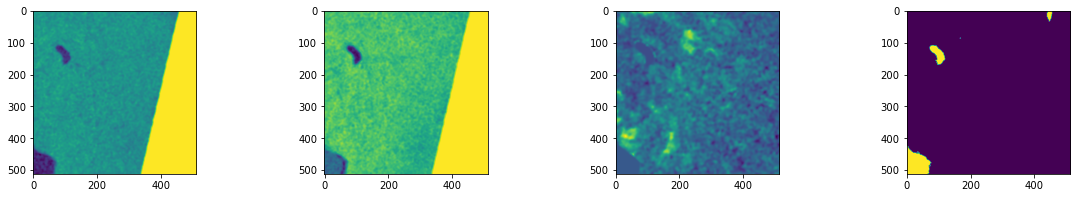

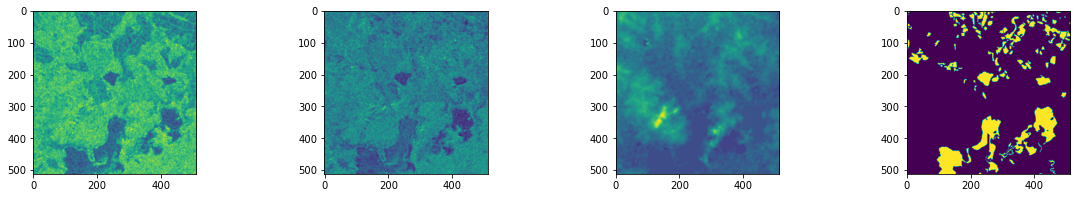

In [10]:
traingen = CustomDataGen(filenames, channels=3, input_shape=512, batch_size=4)

for x, y in traingen:
    break

i = 0
    
for xx, yy in zip(x, y):

    _, ax = plt.subplots(1, 4, figsize=(20, 3))
    for i in range(3):
        ax[i].imshow(xx[:, :, i])
    ax[3].imshow(yy)
    plt.show()

# Model

## Functions

In [11]:
def plot_preds(epoch, logs):
    
    path = val_filenames[0]
    
    with rasterio.open('train_features/{}_vv.tif'.format(path)) as fvv:
        vv = fvv.read(1)
    with rasterio.open('train_features/{}_vh.tif'.format(path)) as fvh:
        vh = fvh.read(1)
    
    with rasterio.open('train_features/{}_nasadem.tif'.format(path)) as nasadem_:
        nasadem = nasadem_.read(1)
    with rasterio.open('train_features/{}_jrc-gsw-change.tif'.format(path)) as jrc_gsw_change_:
        jrc_gsw_change = jrc_gsw_change_.read(1)
    with rasterio.open('train_features/{}_jrc-gsw-extent.tif'.format(path)) as jrc_gsw_extent_:
        jrc_gsw_extent = jrc_gsw_extent_.read(1)
    with rasterio.open('train_features/{}_jrc-gsw-occurrence.tif'.format(path)) as jrc_gsw_occurrence_:
        jrc_gsw_occurrence = jrc_gsw_occurrence_.read(1)
    with rasterio.open('train_features/{}_jrc-gsw-recurrence.tif'.format(path)) as jrc_gsw_recurrence_:
        jrc_gsw_recurrence = jrc_gsw_recurrence_.read(1)
    with rasterio.open('train_features/{}_jrc-gsw-seasonality.tif'.format(path)) as jrc_gsw_seasonality_:
        jrc_gsw_seasonality = jrc_gsw_seasonality_.read(1)
    with rasterio.open('train_features/{}_jrc-gsw-transitions.tif'.format(path)) as jrc_gsw_transitions_:
        jrc_gsw_transitions = jrc_gsw_transitions_.read(1)
                
    mask = process_mask(gdal.Open('train_labels/{}.tif'.format(path)).ReadAsArray())
    
    if N_CHANNELS == 2:
        X = np.zeros((INP_SHAPE, INP_SHAPE, 2))
        X[:, :, 0] = (vh - (-17.54)) / 5.15
        X[:, :, 1] = (vv - (-10.68)) / 4.62
        
    elif N_CHANNELS == 3:
        X = np.zeros((INP_SHAPE, INP_SHAPE, 3))
        X[:, :, 0] = (vh - (-17.54)) / 5.15
        X[:, :, 1] = (vv - (-10.68)) / 4.62
        X[:, :, 2] = (nasadem - (166.47)) / 178.47
        
    elif N_CHANNELS == 9:
        X = np.zeros((INP_SHAPE, INP_SHAPE, 9))
        X[:, :, 0] = (vh - (-17.54)) / 5.15
        X[:, :, 1] = (vv - (-10.68)) / 4.62
        X[:, :, 2] = (nasadem - (166.47)) / 178.47
        X[:, :, 3] = (jrc_gsw_change - 238.76) / 45.45
        X[:, :, 4] = (jrc_gsw_occurrence - 6.50) / 29.06
        X[:, :, 5] = (jrc_gsw_extent - 2.15) / 22.71
        X[:, :, 6] = (jrc_gsw_recurrence - 10.04) / 33.21
        X[:, :, 7] = (jrc_gsw_seasonality - 2.60) / 22.79
        X[:, :, 8] = (jrc_gsw_transitions - 0.55) / 1.94
    
    prediction = model.predict(X[np.newaxis, ...])[0, :, :, 0]
    
    pred_thresh = prediction.copy()
    pred_thresh[pred_thresh > 0.5] = 1
    pred_thresh[pred_thresh <= 0.5] = 0
    pred_thresh = pred_thresh.astype(int)
    
    _, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].imshow(X[:, :, 0])
    ax[0].set_title('vh')
    ax[1].imshow(mask)
    ax[1].set_title('gt')
    ax[2].imshow(prediction)
    ax[2].set_title('pred')
    ax[3].imshow(pred_thresh)
    ax[3].set_title('thresh_pred')
    plt.suptitle(jaccard_score(mask.flatten(), pred_thresh.flatten()))
    plt.show()

In [12]:
def bce_jaccard_loss(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    
    return (1 - jac) * smooth + tf.keras.losses.binary_crossentropy(y_true, y_pred)

#Keras
ALPHA = 0.8
GAMMA = 2

def focal_bce_jaccard_loss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return bce_jaccard_loss(targets, inputs) + focal_loss

## EfficientB0Unet model on 3 bands

In [13]:
INP_SHAPE = 512
N_CHANNELS = 3
BATCH_SIZE = 4

In [14]:
K.clear_session()

model = sm.Unet('efficientnetb0', input_shape=(INP_SHAPE, INP_SHAPE, N_CHANNELS), 
                encoder_weights=None, weights=None)

metrics = [
    'mae',
    'accuracy'
]

model.compile(optimizer=Adam(), 
              loss=bce_jaccard_loss,
              metrics=metrics)

In [15]:
checkpoint_path = 'unet_models/EffUnetB0_{}_{}.h5'.format(INP_SHAPE, N_CHANNELS)
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False),
    LambdaCallback(on_epoch_end=plot_preds)
]

In [16]:
train_filenames, val_filenames = train_test_split(meta.chip_id.values, stratify=meta.location, test_size=0.15)

train_datagen = CustomDataGen(train_filenames, channels=N_CHANNELS, 
                              input_shape=INP_SHAPE, batch_size=BATCH_SIZE)

val_datagen = CustomDataGen(val_filenames, channels=N_CHANNELS, input_shape=INP_SHAPE, 
                            batch_size=BATCH_SIZE, augment=False)

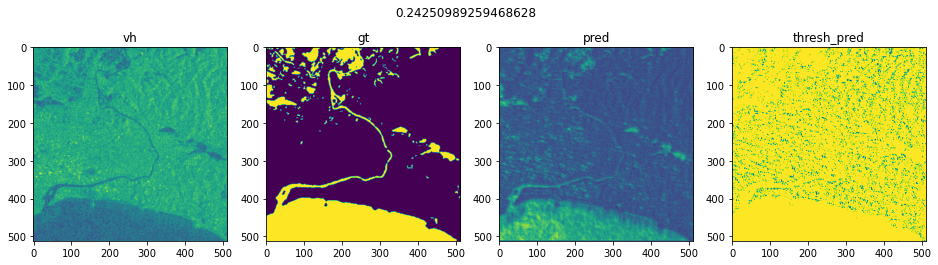

In [17]:
plot_preds(0, 0)

In [18]:
results = model.fit(train_datagen, validation_data=val_datagen,
                    epochs=100, callbacks=callbacks)

## Similar model, but on weaker data

The idea – to select the most poorly segmented images and train a new model on them.

### Data selection

In [20]:
model = load_model('models/unet_models/EffUnetB0_512_3.h5', 
                   custom_objects={'FixedDropout': Dropout,
                                   'bce_jaccard_loss': bce_jaccard_loss})

In [21]:
def plot_val(path, plot=True):
    
    with rasterio.open('train_features/{}_vv.tif'.format(path)) as fvv:
        vv = fvv.read(1)
    with rasterio.open('train_features/{}_vh.tif'.format(path)) as fvh:
        vh = fvh.read(1)
    with rasterio.open('train_features/{}_nasadem.tif'.format(path)) as nasadem_:
        nasadem = nasadem_.read(1)
        
    mask = process_mask(gdal.Open('train_labels/{}.tif'.format(path)).ReadAsArray())
        
    X = np.zeros((INP_SHAPE, INP_SHAPE, 3))
    X[:, :, 0] = (vh - (-17.54)) / 5.15
    X[:, :, 1] = (vv - (-10.68)) / 4.62
    X[:, :, 2] = (nasadem - (166.47)) / 178.47
        
    mask = process_mask(gdal.Open('train_labels/{}.tif'.format(path)).ReadAsArray())
    
    pred = model.predict(X[np.newaxis, :, :, :])[0, :, :, 0]
    
    pred_thresh = pred.copy()
    pred_thresh[pred_thresh > 0.5] = 1
    pred_thresh[pred_thresh <= 0.5] = 0
    pred_thresh = pred_thresh.astype(int)
    
    if plot:
        _, ax = plt.subplots(1, 4, figsize=(16, 4))
    
        ax[0].imshow(X[:, :, 0])
        ax[0].set_title('vh')
        ax[1].imshow(mask)
        ax[1].set_title('gt')
        ax[2].imshow(prediction)
        ax[2].set_title('pred')
        ax[3].imshow(pred_thresh)
        ax[3].set_title('thresh_pred')
        
        if mask.sum() == 0 and pred_thresh.sum() == 0:
            iou = 1
        else:
            intersection = np.logical_and(mask, pred_thresh).sum()
            union = np.logical_or(mask, pred_thresh).sum()
            iou = intersection / union
        plt.suptitle(iou)
        plt.show()
    
    return pred_thresh, mask

In [25]:
ious = []

for i in tqdm(range(len(filenames))):
    
    intersection = 0
    union = 0
    
    pred, actual = plot_val(filenames[i], plot=False)

    intersection += np.logical_and(actual, pred).sum()
    union += np.logical_or(actual, pred).sum()
    
    if actual.sum() == 0 and pred.sum() == 0:
        iou = 1
    else:
        iou = intersection / union

    ious.append(iou)

100%|██████████| 542/542 [01:13<00:00,  7.41it/s]


In [26]:
data = pd.DataFrame()
data['file'] = filenames
data['iou'] = ious
weak_files = data[data.iou < 0.75].file.values
print(len(weak_files))
weak_files = meta[meta.chip_id.isin(weak_files)].reset_index(drop=True)

542


In [27]:
weak_files

image_id chip_id flood_id polarization location scene_start
0    awc00_vh   awc00      awc           vh  Bolivia  2018-02-15
1    awc01_vh   awc01      awc           vh  Bolivia  2018-02-15
2    awc02_vh   awc02      awc           vh  Bolivia  2018-02-15
3    awc03_vh   awc03      awc           vh  Bolivia  2018-02-15
4    awc04_vh   awc04      awc           vh  Bolivia  2018-02-15
..        ...     ...      ...          ...      ...         ...
537  wvy27_vh   wvy27      wvy           vh       UK  2019-02-15
538  wvy28_vh   wvy28      wvy           vh       UK  2019-02-15
539  wvy29_vh   wvy29      wvy           vh       UK  2019-02-15
540  wvy30_vh   wvy30      wvy           vh       UK  2019-02-15
541  wvy31_vh   wvy31      wvy           vh       UK  2019-02-15

[542 rows x 6 columns]

### Model fitting

In [28]:
INP_SHAPE = 512
N_CHANNELS = 3
BATCH_SIZE = 4

In [29]:
K.clear_session()

model = sm.Unet('efficientnetb0', input_shape=(INP_SHAPE, INP_SHAPE, N_CHANNELS), 
                encoder_weights=None, weights=None)

metrics = [
    'mae',
    'accuracy'
]

model.compile(optimizer=Adam(), 
              loss=bce_jaccard_loss,
              metrics=metrics)

In [30]:
checkpoint_path = 'unet_models/EffUnetB0_{}_{}_weak_1.h5'.format(INP_SHAPE, N_CHANNELS)
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False),
    LambdaCallback(on_epoch_end=plot_preds)
]

In [31]:
train_filenames, val_filenames = train_test_split(weak_files.chip_id.values, 
                                                  stratify=weak_files.location, test_size=0.15)

train_datagen = CustomDataGen(train_filenames, channels=N_CHANNELS, 
                              input_shape=INP_SHAPE, batch_size=BATCH_SIZE)

val_datagen = CustomDataGen(val_filenames, channels=N_CHANNELS, input_shape=INP_SHAPE, 
                            batch_size=BATCH_SIZE, augment=False)

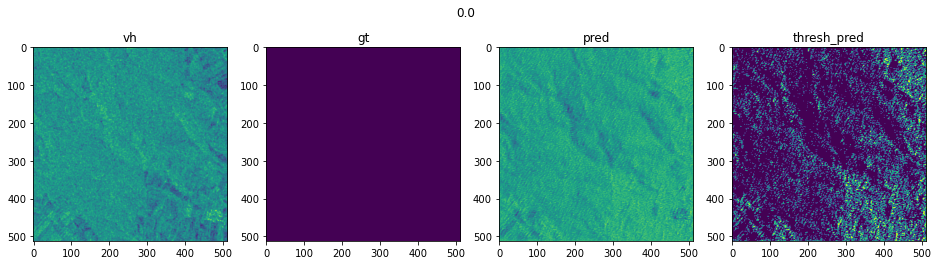

In [32]:
plot_preds(0, 0)

In [33]:
results = model.fit(train_datagen, validation_data=val_datagen,
                    epochs=100, callbacks=callbacks)

# StratifiedKFold models with EfficientNetB4 backbone

In [34]:
from sklearn.model_selection import StratifiedKFold

In [35]:
INP_SHAPE = 512
N_CHANNELS = 3
BATCH_SIZE = 4

In [36]:
k = 0

for train_x, val_x in StratifiedKFold(n_splits=5).split(meta.chip_id.values, meta.location):
    
    train_files = meta.chip_id.iloc[train_x].values
    val_files = meta.chip_id.iloc[val_x].values
    
    K.clear_session()

    model = sm.Unet('efficientnetb4', input_shape=(INP_SHAPE, INP_SHAPE, N_CHANNELS), 
                    encoder_weights=None, weights=None)
    
    metrics = ['mae', 'accuracy']
    model.compile(optimizer=Adam(), loss=bce_jaccard_loss, metrics=metrics)
    
    checkpoint_path = 'unet_models/EfficientB4Unet_{}_{}_{}.h5'.format(INP_SHAPE, N_CHANNELS, k)
    k += 1
    
    callbacks = [
        EarlyStopping(patience=15, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
        ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False),
        LambdaCallback(on_epoch_end=plot_preds)
    ]
    
    train_datagen = CustomDataGen(train_files, channels=N_CHANNELS, 
                                  input_shape=INP_SHAPE, batch_size=BATCH_SIZE)
    val_datagen = CustomDataGen(val_files, channels=N_CHANNELS, 
                                input_shape=INP_SHAPE, batch_size=BATCH_SIZE, augment=False)
    
    results = model.fit(train_datagen, validation_data=val_datagen,
                        epochs=70, callbacks=callbacks)

# Testing

## Functions

In [37]:
def plot_val(path, models, plot=True):
    
    with rasterio.open('train_features/{}_vv.tif'.format(path)) as fvv:
        vv = fvv.read(1)
    with rasterio.open('train_features/{}_vh.tif'.format(path)) as fvh:
        vh = fvh.read(1)
    with rasterio.open('train_features/{}_nasadem.tif'.format(path)) as nasadem_:
        nasadem = nasadem_.read(1)
                
    mask = process_mask(gdal.Open('train_labels/{}.tif'.format(path)).ReadAsArray())
        
    X = np.zeros((INP_SHAPE, INP_SHAPE, 3))
    X[:, :, 0] = (vh - (-17.54)) / 5.15
    X[:, :, 1] = (vv - (-10.68)) / 4.62
    X[:, :, 2] = (nasadem - (166.47)) / 178.47
        
    mask = process_mask(gdal.Open('train_labels/{}.tif'.format(path)).ReadAsArray())
    
    preds = []
    
    for model in models:
        pred = model.predict(X[np.newaxis, :, :, :])[0, :, :, 0]
        preds.append(pred)
        
    pred = np.mean(preds, axis=0)
        
    pred_thresh = pred.copy()
    pred_thresh[pred_thresh > 0.5] = 1
    pred_thresh[pred_thresh <= 0.5] = 0
    pred_thresh = pred_thresh.astype(int)
    
    if plot:
        _, ax = plt.subplots(1, 4, figsize=(16, 4))
    
        ax[0].imshow(X[:, :, 0])
        ax[0].set_title('vh')
        ax[1].imshow(mask)
        ax[1].set_title('gt')
        ax[2].imshow(pred)
        ax[2].set_title('pred')
        ax[3].imshow(pred_thresh)
        ax[3].set_title('thresh_pred')
        if mask.sum() == 0 and pred_thresh.sum() == 0:
            iou = 1
        else:
            intersection = np.logical_and(mask, pred_thresh).sum()
            union = np.logical_or(mask, pred_thresh).sum()
            iou = intersection / union
        plt.suptitle(iou)
        plt.show()
    
    return pred, mask

## Let's test it

In [39]:
models_simple = []

models_simple.append(load_model('models/unet_models/EffUnetB0_512_3.h5', 
                                custom_objects={'FixedDropout': Dropout,
                                                'bce_jaccard_loss': bce_jaccard_loss}))
                     
models_simple.append(load_model('models/unet_models/EffUnetB0_512_3_weak_1.h5', 
                                custom_objects={'FixedDropout': Dropout,
                                                'bce_jaccard_loss': bce_jaccard_loss}))

In [41]:
models_skf = []

for i in range(5):
    models_skf.append(load_model('models/unet_models/EfficientB4Unet_512_3_{}.h5'.format(i), 
                                 custom_objects={'FixedDropout': Dropout,
                                                 'bce_jaccard_loss': bce_jaccard_loss}))

first models


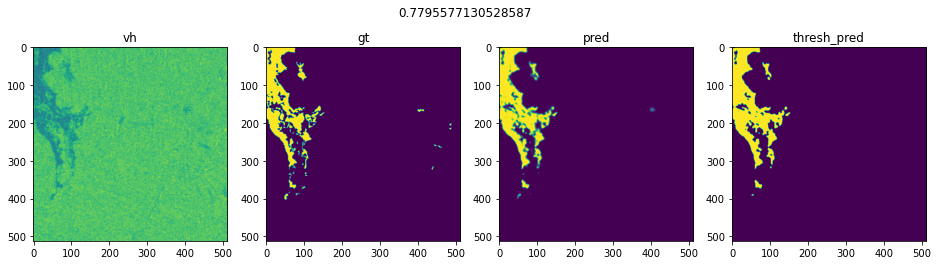

skf models


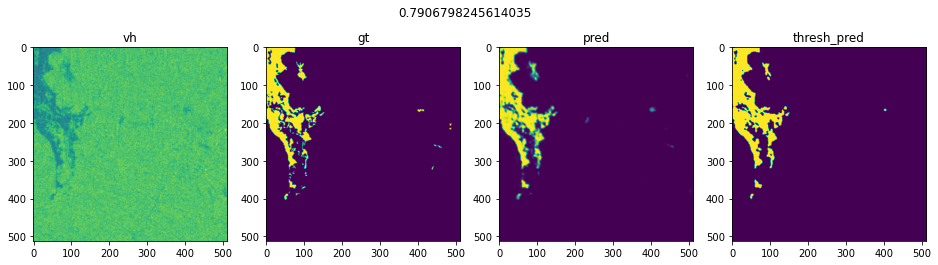

all models


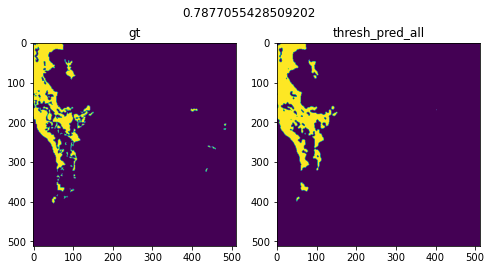


<–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––>

first models


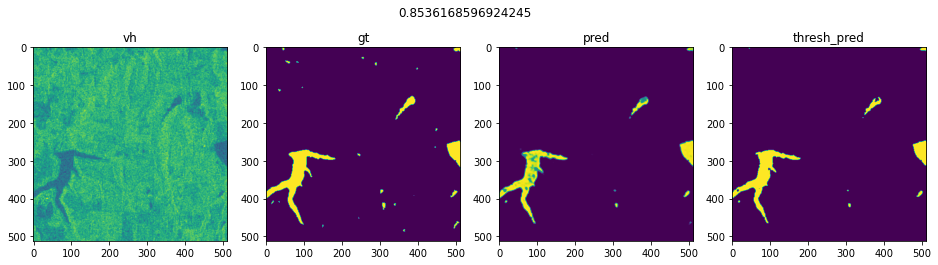

skf models


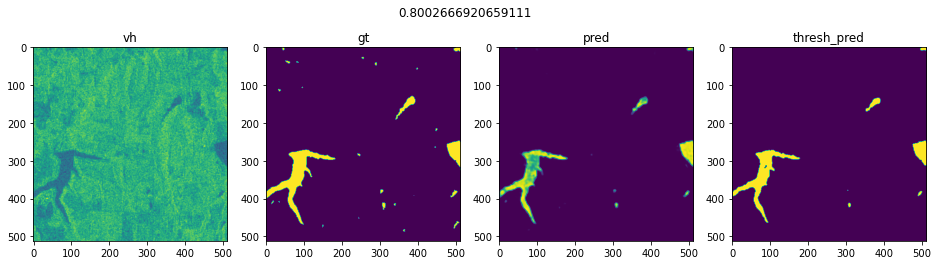

all models


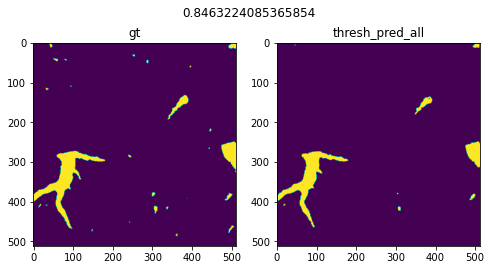


<–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––>

first models


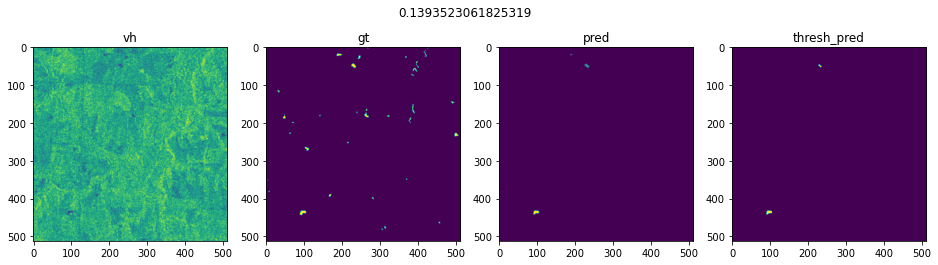

skf models


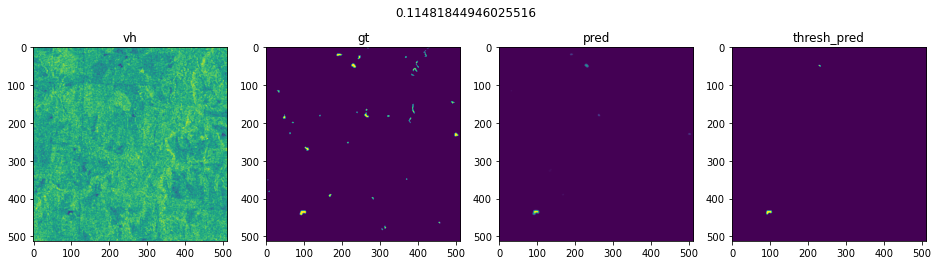

all models


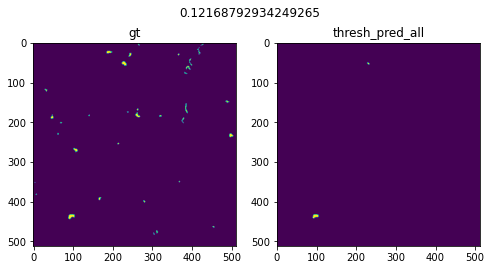


<–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––>

first models


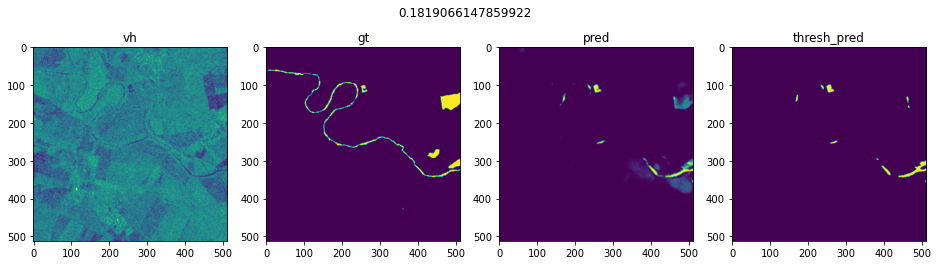

skf models


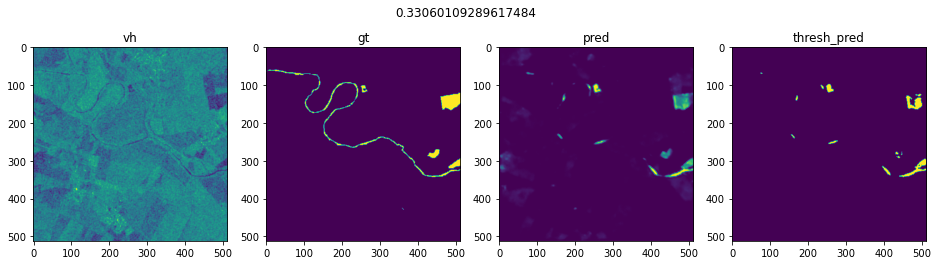

all models


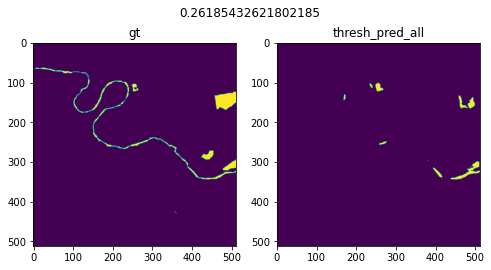


<–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––>

first models


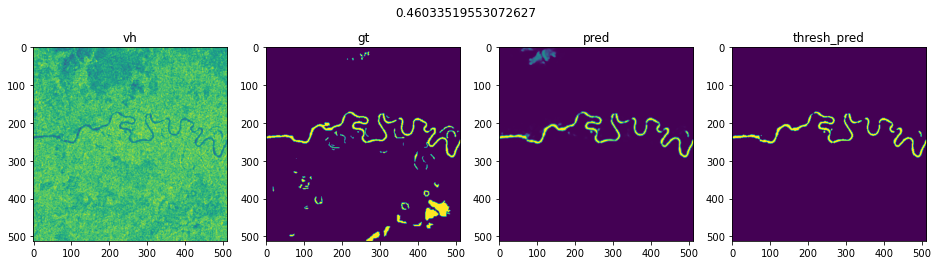

skf models


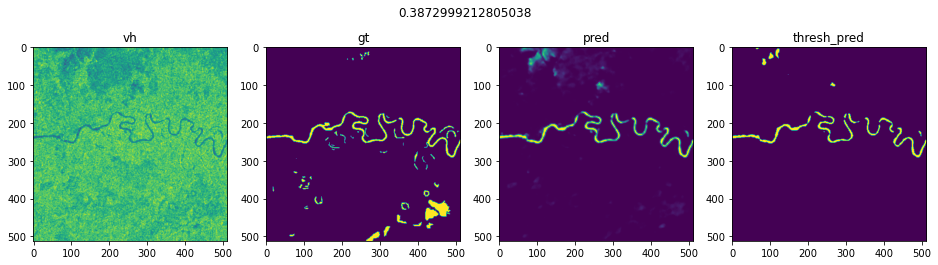

all models


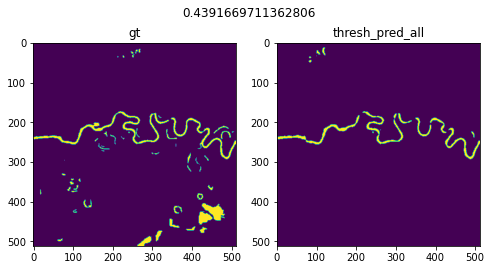


<–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––>

first models


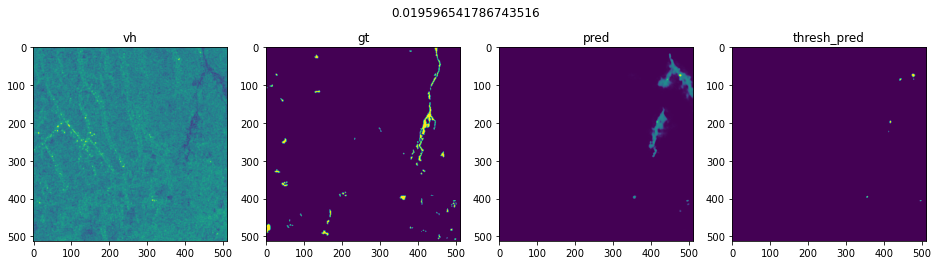

skf models


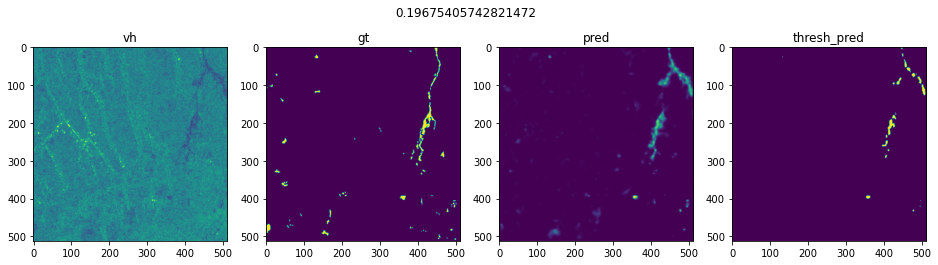

all models


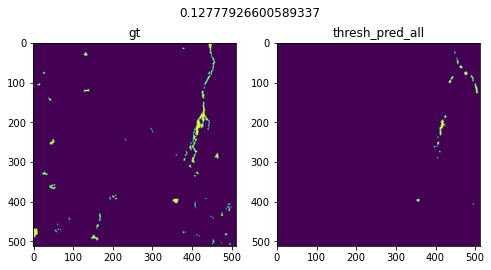


<–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––>

first models


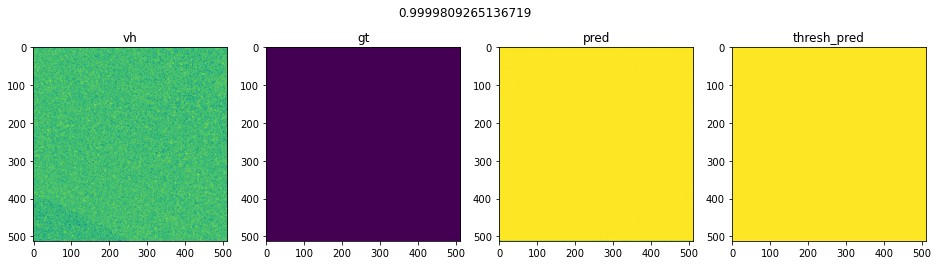

skf models


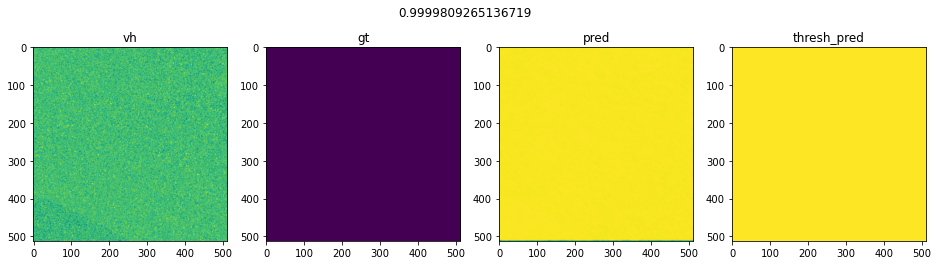

all models


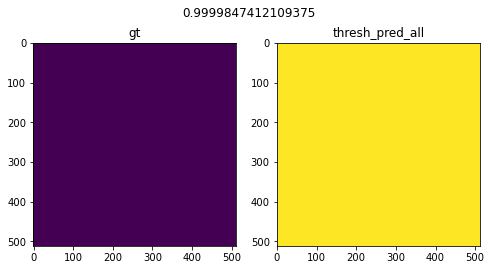


<–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––>

first models


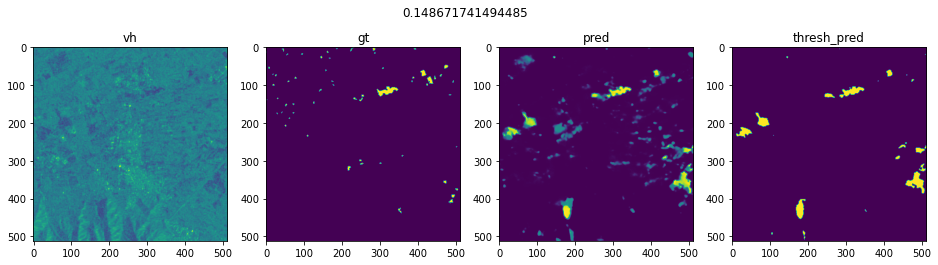

skf models


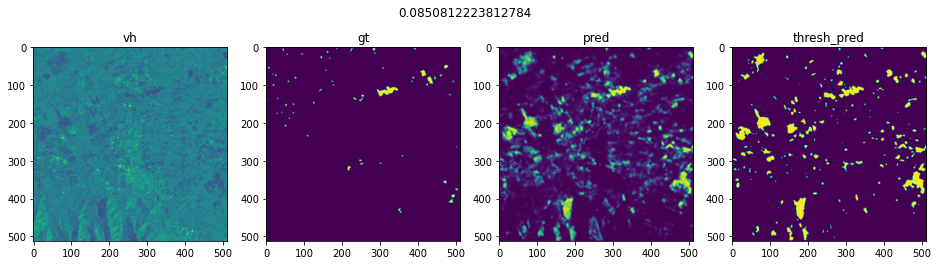

all models


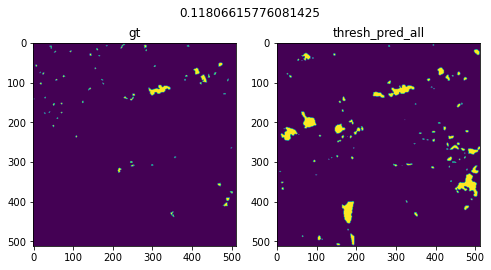


<–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––>

first models


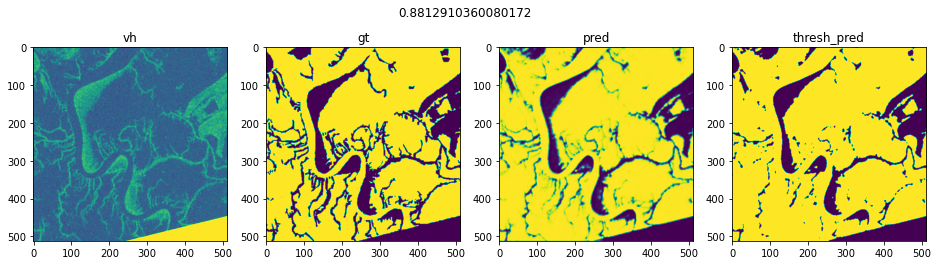

skf models


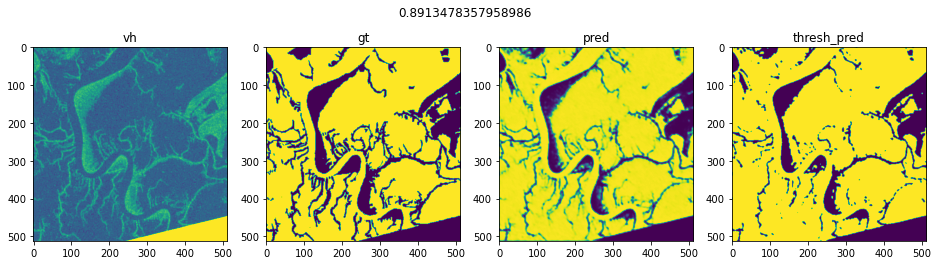

all models


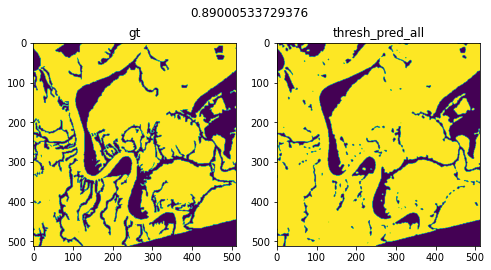


<–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––>

first models


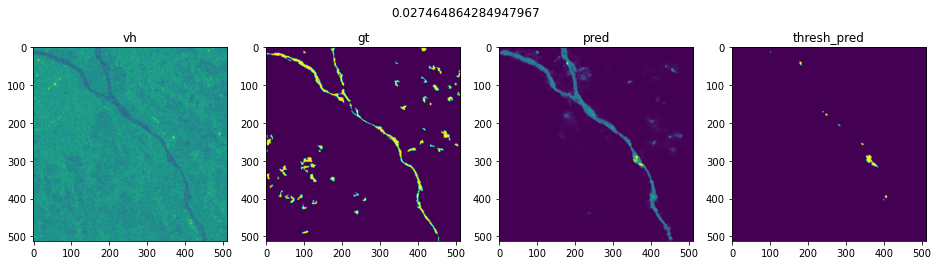

skf models


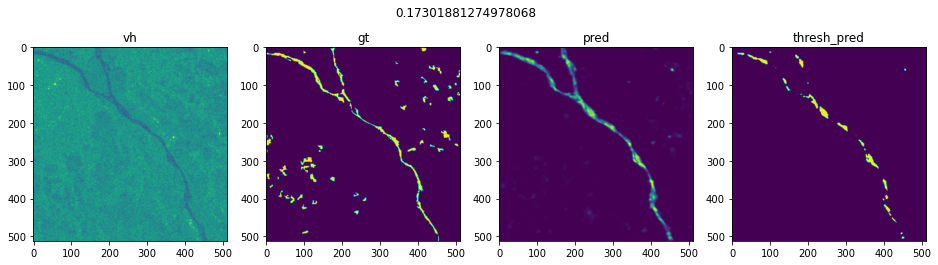

all models


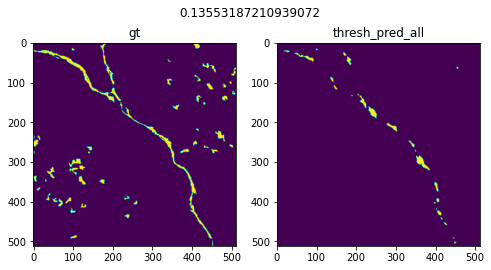


<–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––>



In [92]:
for f in pd.Series(filenames).sample(10).values:
    
    print('first models')
    pred_1, _ = plot_val(f, models_simple)
    
    print('skf models')
    pred_2, mask  = plot_val(f, models_skf)
    
    pred_all = np.mean([pred_1, pred_2], axis=0)
    pred_thresh = pred_all.copy()
    pred_thresh[pred_thresh > 0.5] = 1
    pred_thresh[pred_thresh <= 0.5] = 0
    pred_thresh = pred_thresh.astype(int)
    
    print('all models')
    _, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(mask)
    ax[0].set_title('gt')
    ax[1].imshow(pred_thresh)
    ax[1].set_title('thresh_pred_all')
    if mask.sum() == 0 and pred_thresh.sum() == 0:
        iou = 1
    else:
        intersection = np.logical_and(mask, pred_thresh).sum()
        union = np.logical_or(mask, pred_thresh).sum()
        iou = intersection / union
    plt.suptitle(iou)
    plt.show()
    
    print('\n<–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––>\n')

In [101]:
intersection = 0
union = 0
ious = []

for f in tqdm(filenames):
    
    pred_1, _ = plot_val(f, models_simple, plot=False)
    pred_2, mask  = plot_val(f, models_skf, plot=False)
    
    pred_all = np.mean([pred_1, pred_2], axis=0)
    
    pred_thresh = pred_all.copy()
    pred_thresh[pred_thresh > 0.5] = 1
    pred_thresh[pred_thresh <= 0.5] = 0
    pred_thresh = pred_thresh.astype(int)

    intersection += np.logical_and(mask, pred_thresh).sum()
    union += np.logical_or(mask, pred_thresh).sum()

    ious.append(intersection / union)

100%|██████████| 542/542 [11:42<00:00,  1.30s/it]


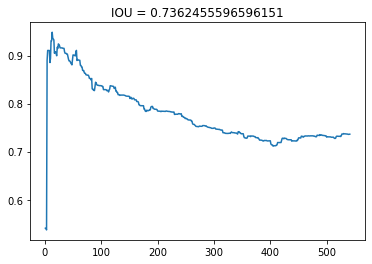

In [102]:
plt.plot(ious)
plt.title('IOU = ' + str(ious[-1]))
plt.show()

# Save some predictions to compare and combine them with CatBoost predictions

In [108]:
compare_files = []
compare_paths = []

for f in tqdm(pd.Series(filenames).sample(20).values):
    
    pred_1, _ = plot_val(f, models_simple, plot=False)
    pred_2, mask  = plot_val(f, models_skf, plot=False)
    
    pred_all = np.mean([pred_1, pred_2], axis=0)
    
    compare_files.append(f)
    compare_paths.append('result_for_compare/unet_'+f)
    np.save('result_for_compare/unet_'+f, pred_all)

100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


In [111]:
compare_df = pd.DataFrame()
compare_df['files'] = compare_files
compare_df['unet_path'] = compare_paths
compare_df.to_csv('compare_df.csv', index=False)